In [9]:
import numpy as np
import librosa
import joblib
import matplotlib.pyplot as plt

# --- CONFIGURATION ---

MODEL_FILES = {'scaler': 'scaler.pkl', 'model': 'rf_model.pkl'}

# Must match training settings exactly
WINDOW_LEN = 1.0  
STEP_LEN = 0.1    # 100ms steps (High resolution)
THRESHOLD = 0.6   # 60% Confidence to trigger an alert

def test_rf_model(file_path):
    print(f"Loading {file_path}...")
    
    # 1. Load Models
    try:
        scaler = joblib.load(MODEL_FILES['scaler'])
        rf = joblib.load(MODEL_FILES['model'])
    except FileNotFoundError:
        print("❌ Error: scaler.pkl or rf_model.pkl not found.")
        return

    # 2. Load Audio
    # We load as mono, 16kHz
    y, sr = librosa.load(file_path, sr=16000)
    
    # Setup Sliding Window
    n_window = int(WINDOW_LEN * sr)
    n_step = int(STEP_LEN * sr)
    
    timestamps = []
    probs = []
    detections = []
    
    print("-" * 50)
    print(f"{'Time':<10} | {'Probability':<12} | {'Status'}")
    print("-" * 50)
    
    # 3. Slide over the file
    for i in range(0, len(y) - n_window, n_step):
        chunk = y[i : i + n_window]
        
        # Extract MFCC (Exactly as in training)
        mfcc = librosa.feature.mfcc(y=chunk, sr=sr, n_mfcc=13)
        # 3. Drop Coefficient 0 (MUST DO)
        mfcc_shape_only = mfcc[1:]             # <--- NEW
        feat = np.mean(mfcc_shape_only.T, axis=0).reshape(1, -1)
        
        # Scale
        feat_scaled = scaler.transform(feat)
        
        # Predict Probability
        # predict_proba returns [[Prob_Class0, Prob_Class1]]
        # We want index 1 (Event)
        prob_event = rf.predict_proba(feat_scaled)[0][1]
        
        # Store Data
        time_sec = i / sr
        timestamps.append(time_sec)
        probs.append(prob_event)
        
        # Check Threshold
        if prob_event >= THRESHOLD:
            status = "🚨 EVENT"
            detections.append((time_sec, prob_event))
            # Print only if detected to keep console clean
            print(f"{time_sec:.2f}s      | {prob_event:.2%}\t    | {status}")
            
    print("-" * 50)
    print(f"✅ Analysis Complete. Found {len(detections)} detection frames.")

    # --- 4. VISUALIZATION ---
    plt.figure(figsize=(14, 6))
    
    # Plot the Probability Curve
    plt.plot(timestamps, probs, label="Event Probability", color='#1f77b4', linewidth=2)
    
    # Plot the Threshold Line
    plt.axhline(THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold ({THRESHOLD:.0%})')
    
    # Fill the "Danger Zone" (Where Prob > Threshold)
    plt.fill_between(timestamps, probs, 0, where=(np.array(probs) >= THRESHOLD), 
                     color='red', alpha=0.3, label="Detection Zone")
    
    # Fill the "Safe Zone" (Background)
    plt.fill_between(timestamps, probs, 0, where=(np.array(probs) < THRESHOLD), 
                     color='green', alpha=0.1)

    plt.ylim(0, 1.05)
    plt.ylabel("Confidence (0% - 100%)")
    plt.xlabel("Time (seconds)")
    plt.title(f"Random Forest Event Detection: {file_path}")
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    
    plt.show()



Loading Jamal.wav...
--------------------------------------------------
Time       | Probability  | Status
--------------------------------------------------
6.20s      | 62.59%	    | 🚨 EVENT
6.70s      | 66.25%	    | 🚨 EVENT
7.10s      | 65.94%	    | 🚨 EVENT
7.20s      | 60.30%	    | 🚨 EVENT
7.30s      | 62.63%	    | 🚨 EVENT
13.20s      | 61.33%	    | 🚨 EVENT
13.30s      | 66.00%	    | 🚨 EVENT
13.40s      | 65.80%	    | 🚨 EVENT
13.50s      | 68.30%	    | 🚨 EVENT
13.60s      | 66.97%	    | 🚨 EVENT
13.70s      | 64.19%	    | 🚨 EVENT
--------------------------------------------------
✅ Analysis Complete. Found 11 detection frames.


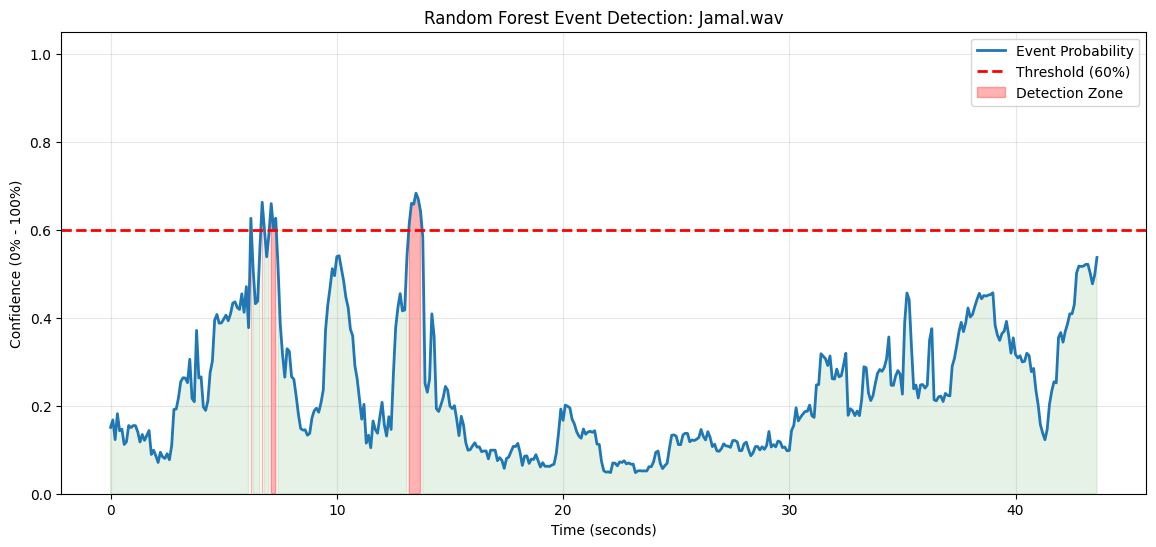

In [12]:
# Run the function
#TEST_FILE = "droneAudio/DJI_Neo_02.wav"  # <--- REPLACE THIS
TEST_FILE = "Jamal.wav"  # <--- REPLACE THIS
test_rf_model(TEST_FILE)